In [16]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

matplotlib.rcParams.update({'font.size': 16})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
def phred(pval):
    return -10 * np.log10(pval)

## Global parameters

In [18]:
signif_thres = phred(0.05)
print('Significance Phred threshold:', signif_thres)

grouping_param = 'DeLong Test - Alternative hypothesis'

score_names = {'orion': 'Orion', 'cadd': 'CADD', 
               'gwrvis': 'gwRVIS', 'gwrvis+cadd': 'gwRVIS + CADD',
               'cdts': 'CDTS', 'dann': 'DANN', 'linsight': 'LINSIGHT',
               'ncER_10bp': 'ncER', 'deepsea': 'DeepSEA'}

out_dir = 'out-figs'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

Significance Phred threshold: 13.010299956639813


## Parse DeLong test's results file

In [19]:
def process_delong_results(input_file, ref_score, remove_plain_jarvis=True):
    df = pd.read_csv(input_file, header=None)
    df.columns = ['aux']

    # remove redundant formatting/characters
    df = df.loc[ df.aux.str.contains('<'), : ]
    df['aux'] = df['aux'].str.replace('\[1\]', '')
    df['aux'] = df['aux'].str.replace('\"', '')
    df['aux'] = df['aux'].str.replace(' ', '')

   
    # Split columns to separate scores under comparison and p-val
    df[['left_score','right_score']] = df.aux.str.split("<", expand=True)
    df[['right_score','pval']] = df['right_score'].str.split(":", expand=True)

    # clean up redundant columsn and/or rows
    df.drop(['aux'], axis=1, inplace=True)
    df = df.loc[ df.left_score != df.right_score , :]
    if remove_plain_jarvis:
        df = df.loc[ df.left_score != 'jarvis' , :]
        df = df.loc[ df.right_score != 'jarvis' , :]

    # calc phred scores from pvals
    df['Phred score'] = df['pval'].astype(float).apply(lambda x: phred(x))
    
    df.reset_index(drop=True, inplace=True)
    
    # Group bi-directional comparisons per score
    df['Query_score'] = None
    df.loc[::2, 'Query_score' ] = df['left_score']

    all_Query_scores = [s for s in df['Query_score'] if s is not None]
    df.loc[1::2, 'Query_score' ] = all_Query_scores
    
    df['Query_score'].replace(score_names, inplace=True)
    
    df.drop(['left_score','right_score'], axis=1, inplace=True)
    
    
    df[grouping_param] = None
    df.loc[::2, grouping_param] =  ref_score + ' > Query_score'
    df.loc[1::2, grouping_param ] = ref_score + ' < Query_score' 
    
    return df

## Plot Phred scores

In [20]:
def plot_phred_scores(df, input_file, title):
    
    df = df[[grouping_param, 'Query_score', 'pval', 'Phred score']]
    df.to_csv(out_dir + '/' + input_file + '.pvals.txt', sep='\t', index=False)
    
    df.sort_values(by=[grouping_param, 'Phred score', 'Query_score'], ascending=False, inplace=True)

    g = sns.catplot(
        data=df, kind="bar",
        x="Query_score", y="Phred score", hue=grouping_param,
        palette="dark", alpha=.7, height=8,
    )
    g.set_xticklabels(rotation=90)

    
    plt.axhline(y=signif_thres, color='r', linestyle='--')
    plt.xlabel('')
    if max(df['Phred score']) > 500:
        plt.ylim(0, 500)
    plt.title(title)
    
    #fig = g.get_figure()
    g.savefig(out_dir + '/' + input_file + '.Phred_plot.pdf') 

<br><br><br><br>
## gwRVIS

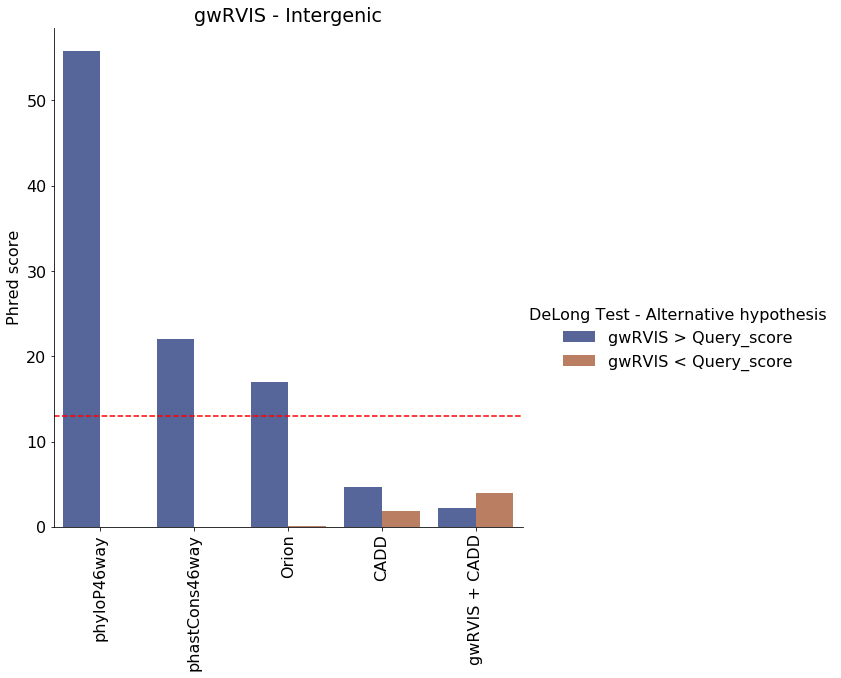

In [62]:
input_file ='gwRVIS_intergenic.delong'
ref_score = 'gwRVIS'

df = process_delong_results(input_file, ref_score)
df = df.loc[:9, :].copy()

plot_phred_scores(df, input_file, 'gwRVIS - Intergenic')

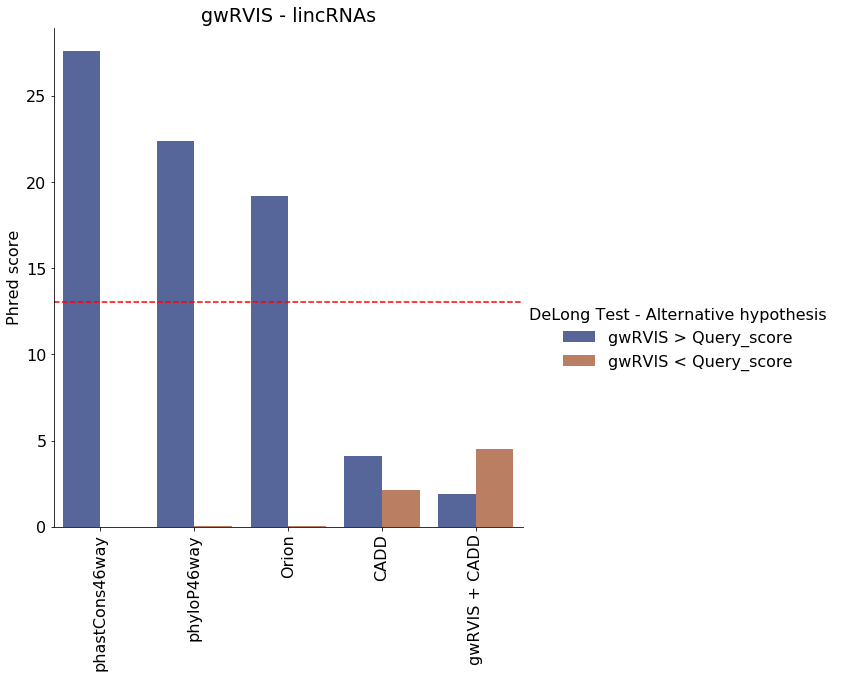

In [64]:
input_file ='gwRVIS_lincrna.delong'
ref_score = 'gwRVIS'

df = process_delong_results(input_file, ref_score)
df = df.loc[:9, :].copy()

plot_phred_scores(df, input_file, 'gwRVIS - lincRNAs')

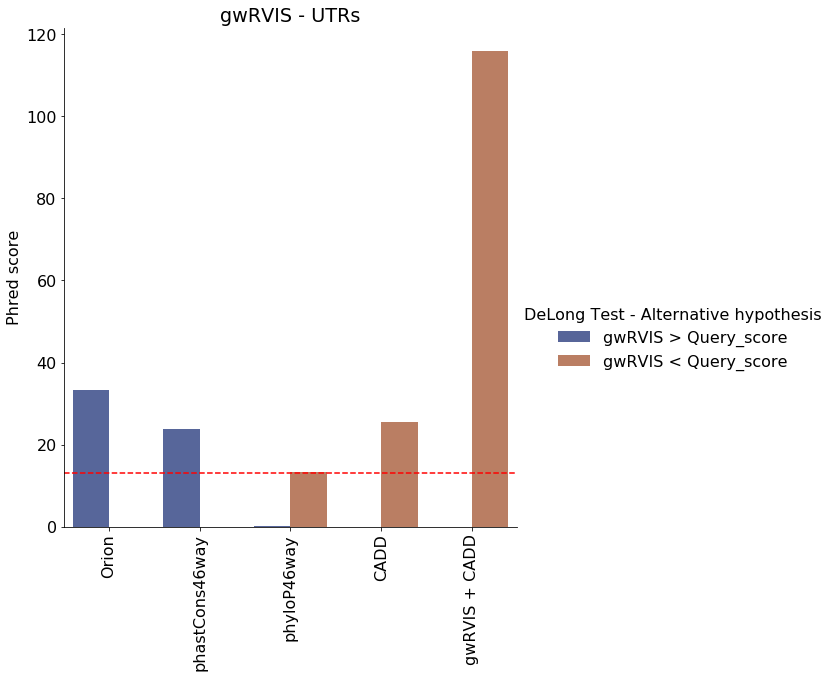

In [65]:
input_file ='gwRVIS_utr.delong'
ref_score = 'gwRVIS'

df = process_delong_results(input_file, ref_score)
df = df.loc[:9, :].copy()

plot_phred_scores(df, input_file, 'gwRVIS - UTRs')

<br><br>
## JARVIS - Training

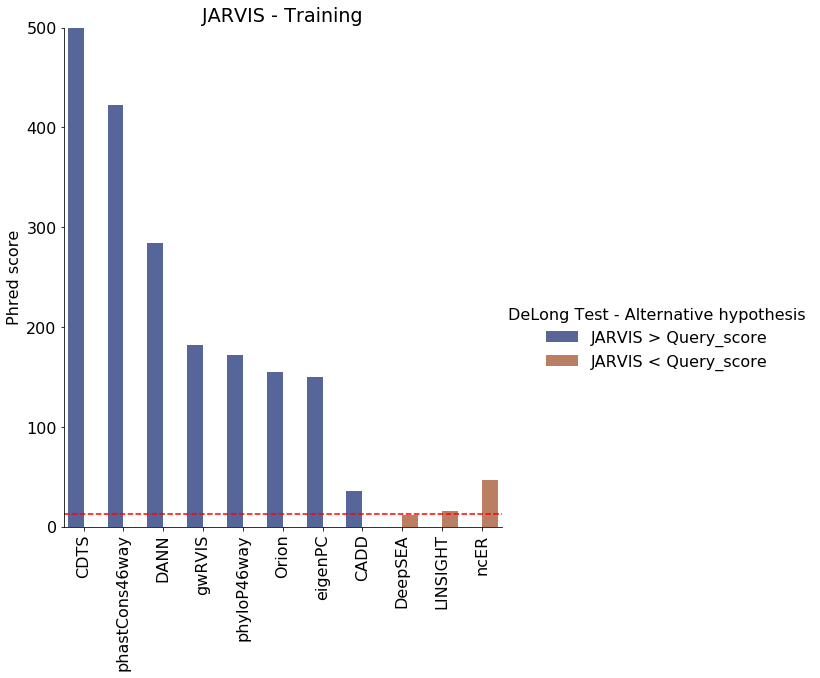

In [67]:
input_file ='Training.DL-Both-delong-results.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Training')

<br><br>
## JARVIS Training (CV Fold split by chromosome)

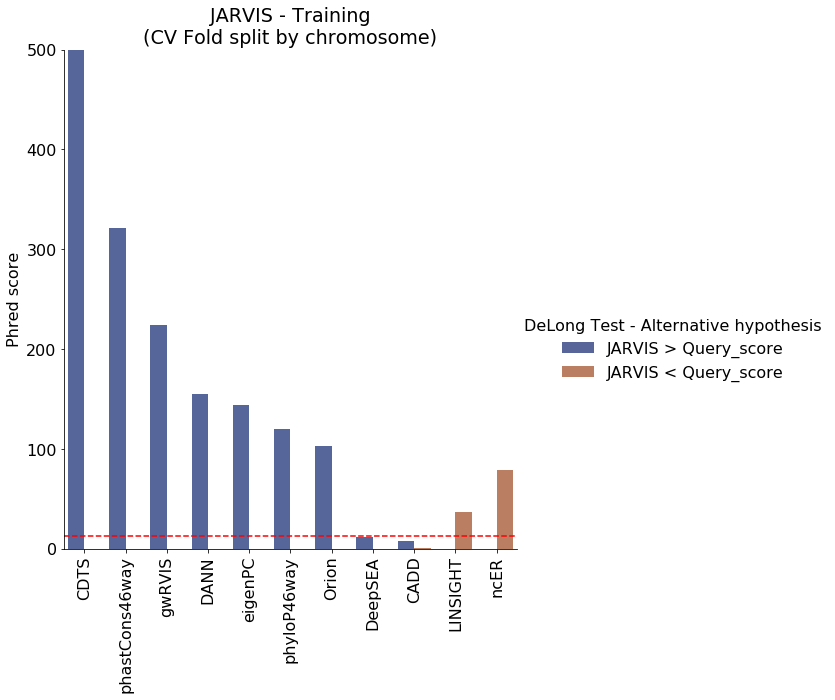

In [11]:
input_file ='Training.DL-Both-delong-results.Split_by_chrom.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Training\n(CV Fold split by chromosome)')

<br><br>
## JARVIS Training (Training set variants matched by TSS distance)

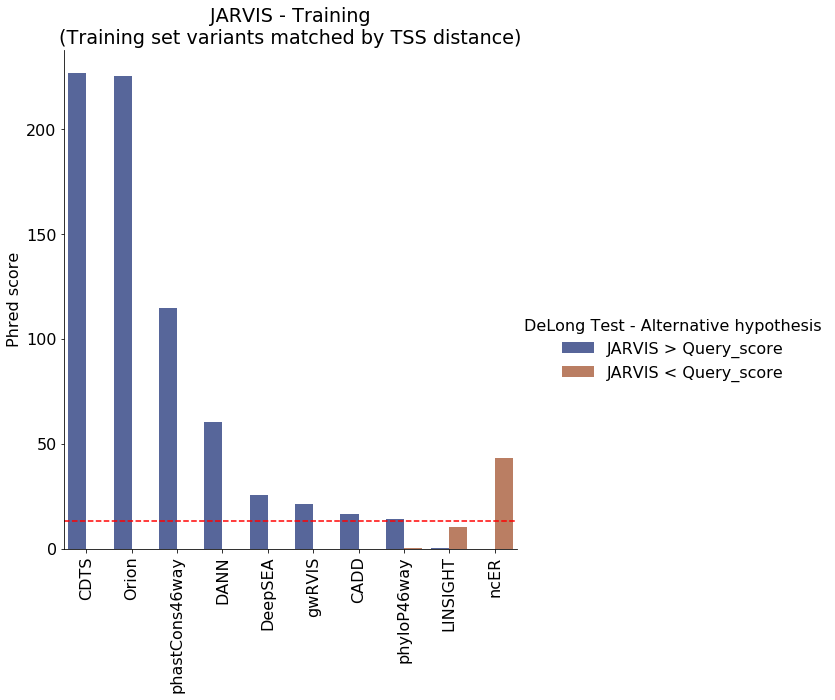

In [8]:
input_file ='Training.DL-Both-delong-results.Matched.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Training\n(Training set variants matched by TSS distance)')

<br><br><br><br>
## JARVIS - Validation on 4 sets

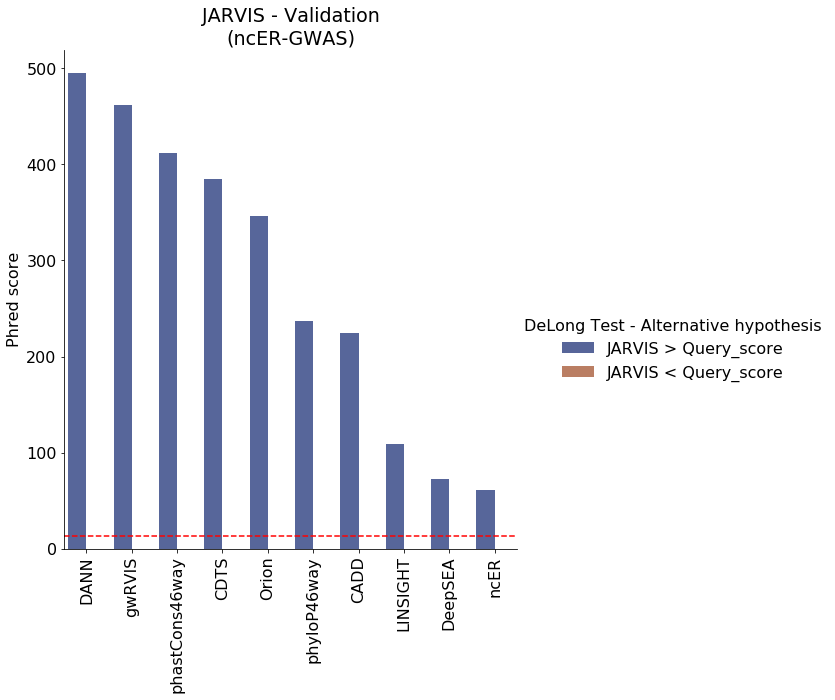

In [70]:
input_file ='Testing.ncER-GWAS.DL-delong-results.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Validation\n(ncER-GWAS)')

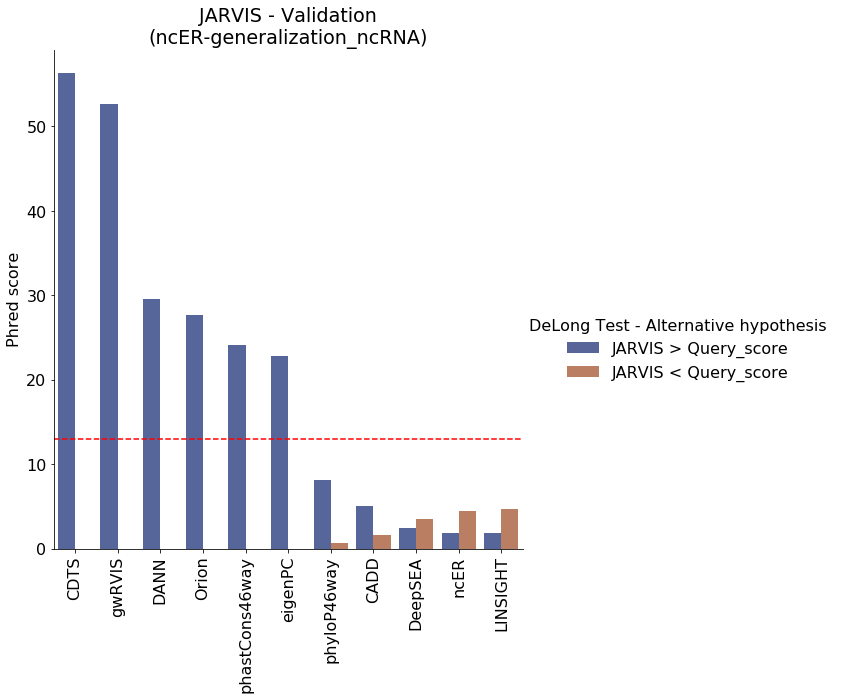

In [71]:
input_file ='Testing.ncER-generalization_ncRNA.DL-delong-results.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Validation\n(ncER-generalization_ncRNA)')

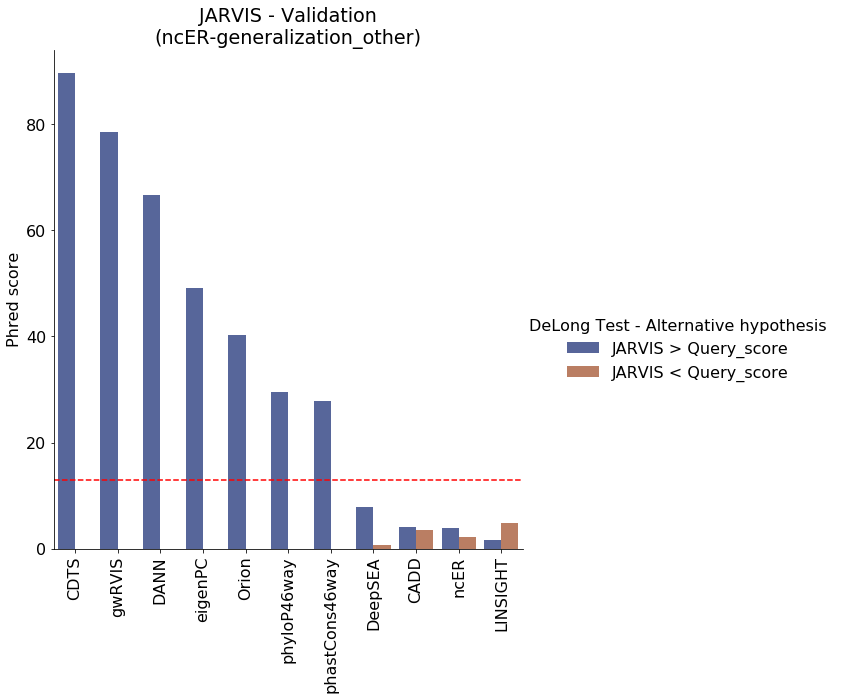

In [15]:
input_file ='Testing.ncER-generalization_other.DL-delong-results.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Validation\n(ncER-generalization_other)')

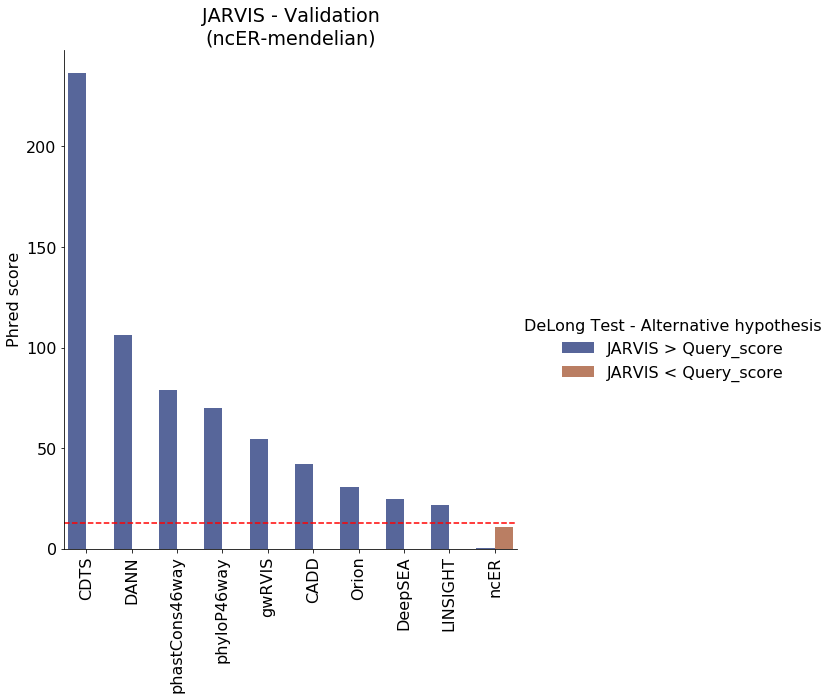

In [73]:
input_file ='Testing.ncER-mendelian.DL-delong-results.txt'
ref_score = 'JARVIS'

df = process_delong_results(input_file, ref_score)

plot_phred_scores(df, input_file, 'JARVIS - Validation\n(ncER-mendelian)')

<br><br><br><br>
## JARVIS - Structural variants

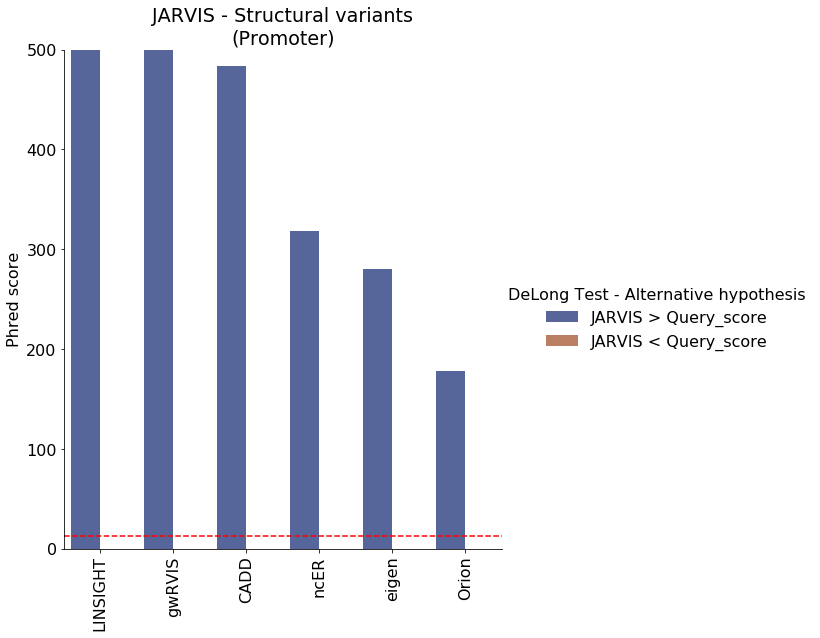

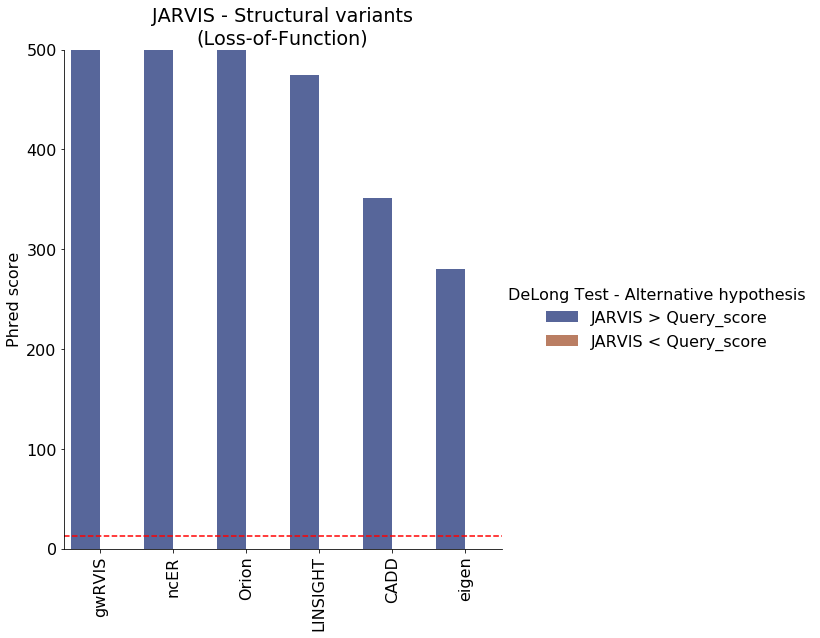

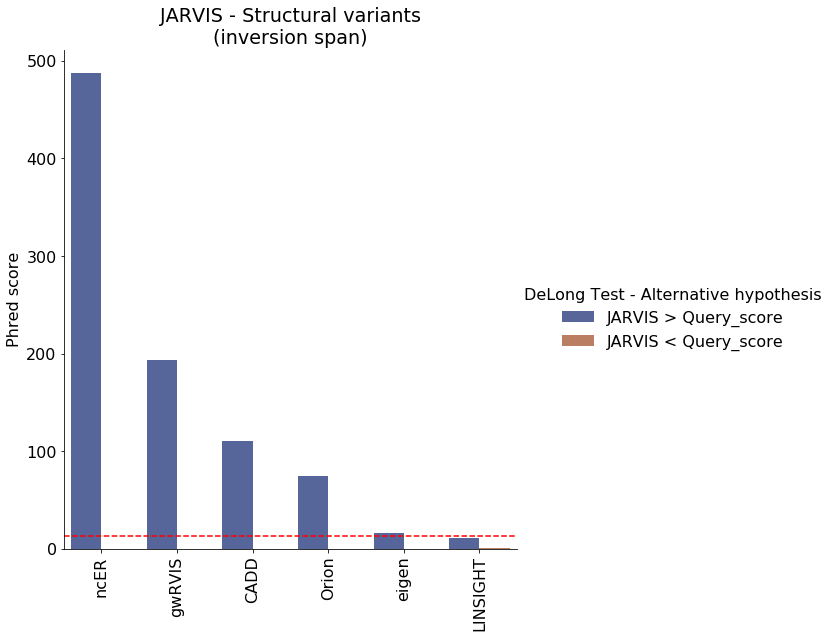

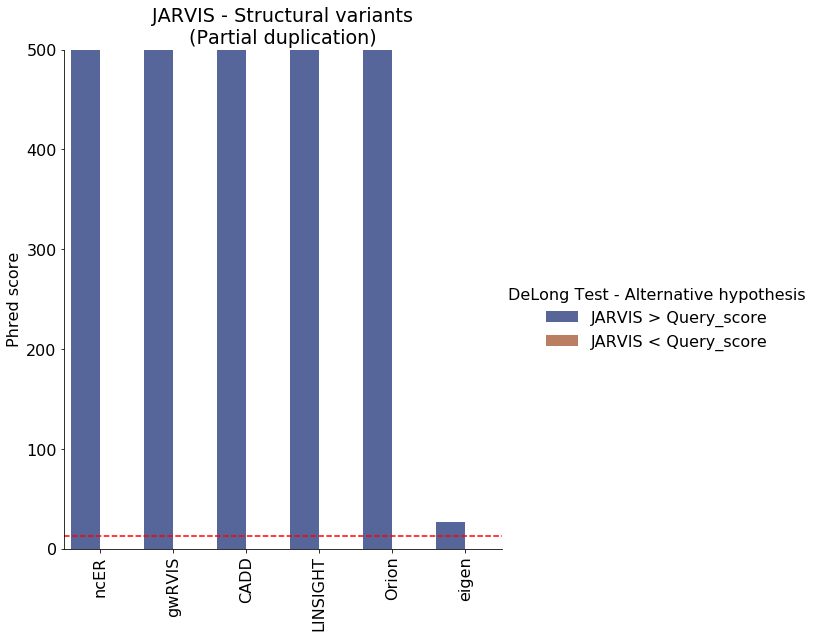

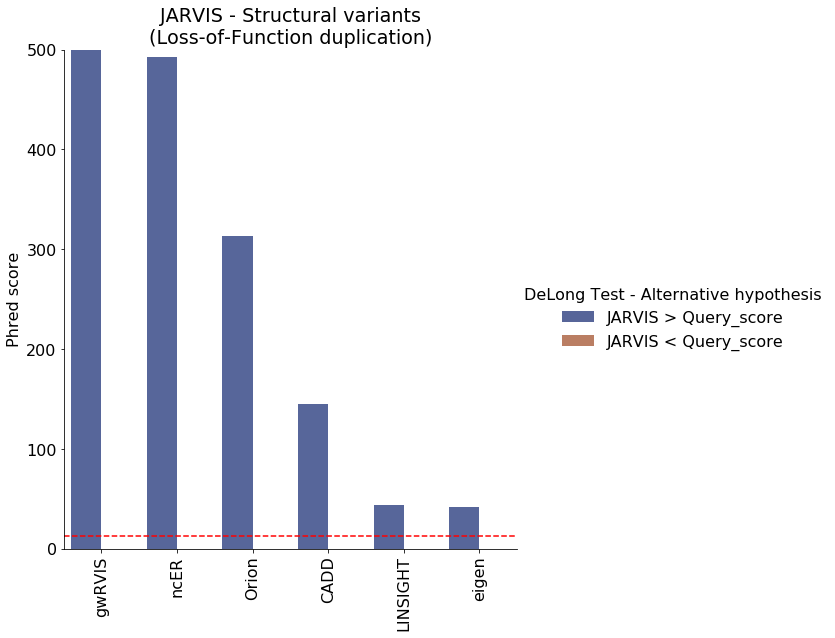

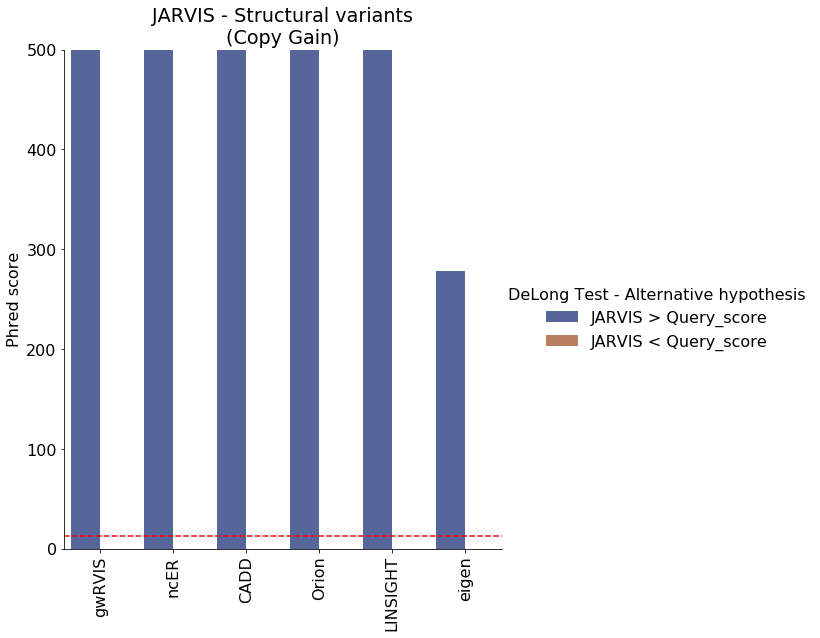

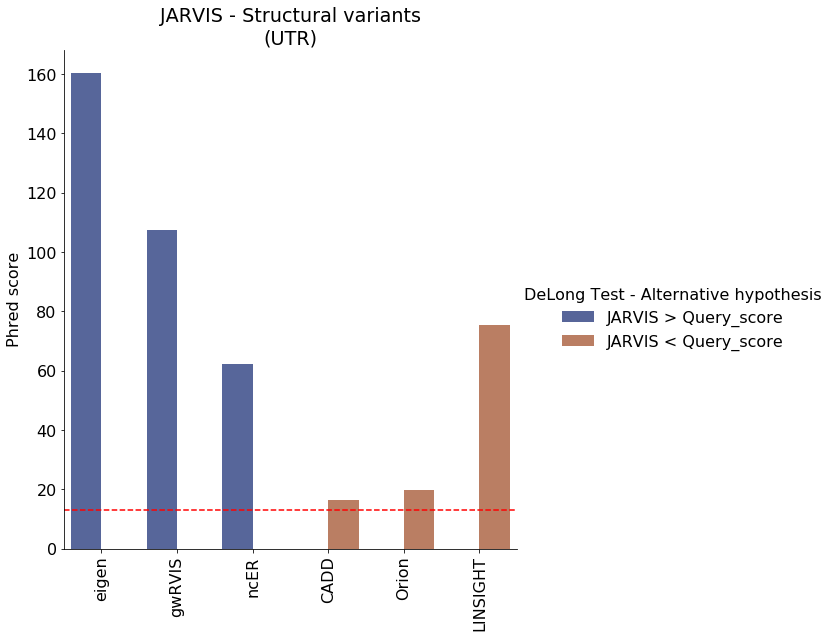

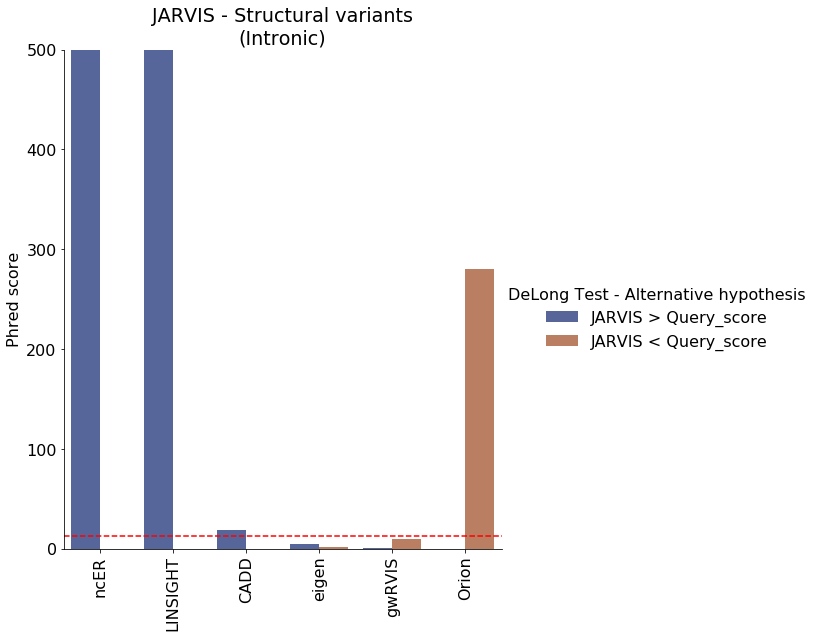

In [21]:
sv_classes = ['promoter', 'lof', 
              'inv_span', 'dup_partial', 
              'dup_lof', 'copy_gain',
              'utr', 'intronic']

sv_print_names = {'utr': 'UTR', 'promoter': 'Promoter', 
                  'lof': 'Loss-of-Function','inv_span': 'inversion span', 
                  'intronic': 'Intronic', 
                  'dup_partial': 'Partial duplication', 
                  'dup_lof': 'Loss-of-Function duplication', 
                  'copy_gain': 'Copy Gain'}

for sv in sv_classes:
    input_file ='SV.' + sv + '.DL-delong-results.txt'
    ref_score = 'JARVIS'

    df = process_delong_results(input_file, ref_score, remove_plain_jarvis=False)

    plot_phred_scores(df, input_file, 'JARVIS - Structural variants\n(' + sv_print_names[sv] + ')')